In [ ]:
import numpy as xp
import matplotlib.pyplot as plt

from arte.types.mask import CircularMask
from arte.atmo.phase_screen_generator import PhaseScreenGenerator

from ekarus.e2e.pyramid_wfs import PyramidWFS
from ekarus.e2e.detector import Detector
from ekarus.e2e.utils.zernike_coefficients import create_field_from_zernike_coefficients

In [7]:
def imageShow(image2d, pixelSize=1, title='', xlabel='', ylabel='', zlabel='', shrink=1.0):
    sz=image2d.shape
    plt.imshow(image2d, extent=[-sz[0]/2*pixelSize, sz[0]/2*pixelSize,
                                -sz[1]/2*pixelSize, sz[1]/2*pixelSize])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar= plt.colorbar(shrink=shrink)
    cbar.ax.set_ylabel(zlabel)

def showZoomCenter(image, pixelSize, **kwargs):
    '''show log(image) zoomed around center'''
    imageHalfSizeInPoints= image.shape[0]/2
    roi= [int(imageHalfSizeInPoints*0.8), int(imageHalfSizeInPoints*1.2)]
    imageZoomedLog= xp.log(image[roi[0]: roi[1], roi[0]:roi[1]])
    imageShow(imageZoomedLog, pixelSize=pixelSize, **kwargs)

rad2arcsec = 180/xp.pi*3600
def compute_pixel_size(wavelength, pupil_diameter_in_m, padding=1):
    return wavelength/pupil_diameter_in_m*rad2arcsec/padding

In [8]:
oversampling = 4

pupilDiameterInM = 30e-3
lambdaInM = 1000e-9
pix2arcsec = compute_pixel_size(wavelength=lambdaInM, pupil_diameter_in_m=pupilDiameterInM, padding = oversampling)
pix2rad = pix2arcsec/rad2arcsec

# Pyramid WFS
apex_angle = 0.0058 # vertex angle in radians, can be tricky to find the right value
wfs = PyramidWFS(apex_angle/pix2rad)

# CCD
detector_shape = (100,100)
ccd = Detector(detector_shape=detector_shape)

# Modulation angle
diameter = 30e-3
alpha = 3*lambdaInM/diameter

In [9]:
# Create the input electric field for flat wavefront (a piston of 1 radians)
nx = 128
mask = CircularMask((oversampling * nx, oversampling * nx), maskRadius=nx // 2)
input_field = create_field_from_zernike_coefficients(mask, 1,1)

# Define detector subapertures
modulated_intensity = wfs.modulate(input_field, alpha/pix2rad, N_steps=16)
subaperture_masks = ccd.define_subaperture_masks(modulated_intensity, Npix = 24)

In [10]:
# Calibration
def perform_calibration(wfs, ccd, Nmodes, zern_amp = 0.1):
    
    IM = xp.zeros((xp.sum(1-ccd.subapertures)//2,Nmodes))
    ZM = xp.zeros((xp.sum(1-mask.mask()),Nmodes))

    for i in range(Nmodes):

        noll = 2 + i
        input_zern = create_field_from_zernike_coefficients(mask, noll, zern_amp)

        ZM[:,i] = xp.angle(input_zern)[~mask.mask()]/zern_amp

        modulated_intensity = wfs.modulate(input_zern, alpha/pix2rad, N_steps=16)
        zern_slopes = ccd.compute_slopes(modulated_intensity)

        IM[:,i] = zern_slopes/zern_amp

    U,S,V = xp.linalg.svd(IM, full_matrices=False)
    Rec = (V.T * 1/S) @ U.T

    return IM, Rec, ZM


N = 10
Nmodes = int(N*(N+1)/2)
IM, Rec, ZM = perform_calibration(wfs, ccd, Nmodes)


In [11]:
zern_ids = xp.arange(Nmodes)+2
zern_amps = 1/zern_ids + xp.random.randn(Nmodes)*0.1

input_wavefront = create_field_from_zernike_coefficients(mask, zern_ids, zern_amps)
wavefront = input_wavefront.copy()

N = 8
meas_zern_amps = xp.zeros([Nmodes,N])

for i in range(N):

    intensity = wfs.modulate(wavefront, alpha/pix2rad, N_steps=16)
    slopes = ccd.compute_slopes(intensity)
    meas_zern_amps[:,i] = Rec @ slopes
    meas_zern_ids = xp.arange(Nmodes)+2

    cmd_wavefront = create_field_from_zernike_coefficients(mask, meas_zern_ids, meas_zern_amps[:,i])

    wavefront *= xp.exp(-1j*xp.angle(cmd_wavefront))



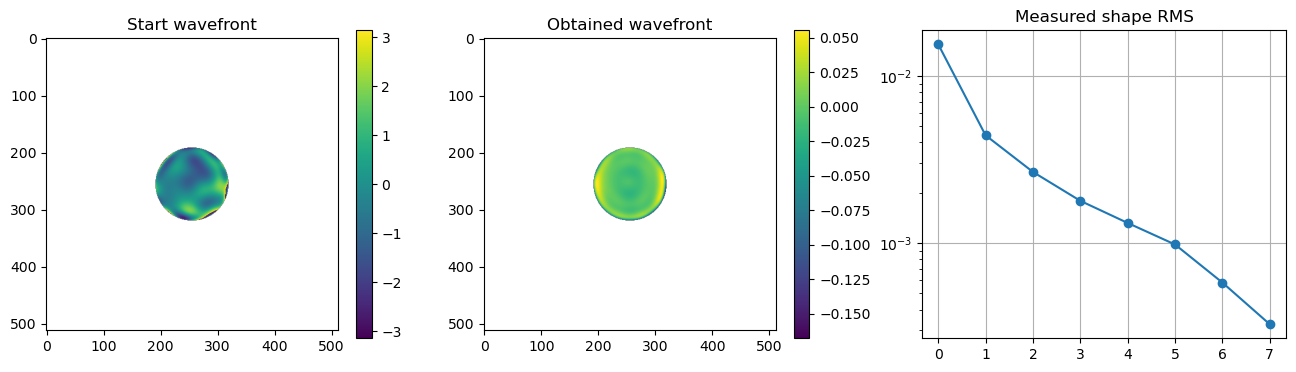

In [12]:
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.imshow(xp.ma.masked_array(xp.angle(input_wavefront),mask=mask.mask()))
plt.colorbar()
plt.title('Start wavefront')

plt.subplot(1,3,2)
plt.imshow(xp.ma.masked_array(xp.angle(wavefront),mask=mask.mask()))
plt.colorbar()
plt.title('Obtained wavefront')

plt.subplot(1,3,3)
plt.plot(xp.arange(N),xp.sqrt(xp.sum(meas_zern_amps**2,axis=0))/Nmodes,'-o')
plt.grid()
plt.title('Measured shape RMS')
plt.yscale('log')

# plt.figure()
# for i in range(N):
#     plt.plot(meas_zern_ids,meas_zern_amps[:,i],label=f'Iteration {i}')
# plt.grid()
# plt.legend()



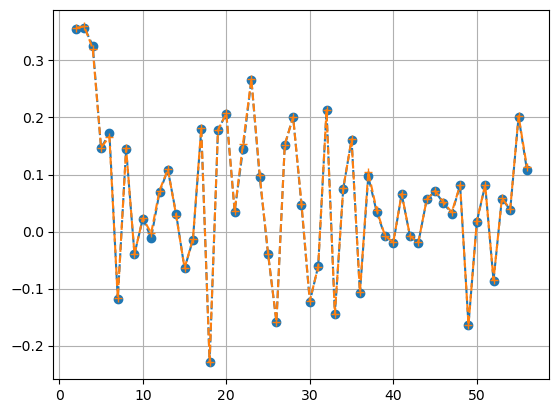

In [13]:
plt.figure()
plt.plot(zern_ids,zern_amps,'--o')
plt.plot(meas_zern_ids,xp.sum(meas_zern_amps,axis=1),'--+')
plt.grid()

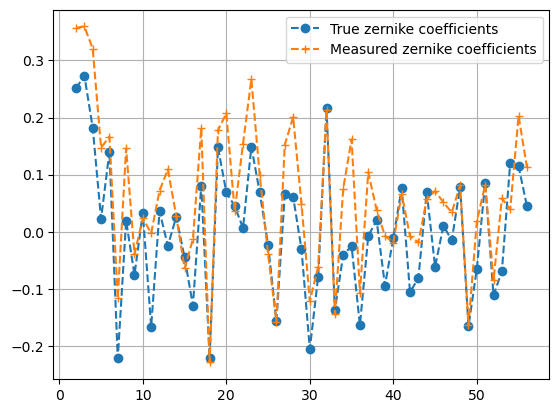

In [14]:
true_zern_amps = xp.linalg.pinv(ZM) @ xp.angle(input_wavefront[~mask.mask()])
plt.figure()
plt.plot(meas_zern_ids,true_zern_amps,'--o',label='True zernike coefficients')
plt.plot(meas_zern_ids,xp.sum(meas_zern_amps,axis=1),'--+',label='Measured zernike coefficients')
plt.legend()
plt.grid()

In [15]:
# from arte.utils.zernike_decomposer import ZernikeModalDecomposer

# zmd = ZernikeModalDecomposer(n_modes=Nmodes)
# true_coeffs = zmd.measureZernikeCoefficientsFromWavefront(input_wavefront,mask,nModes=Nmodes)

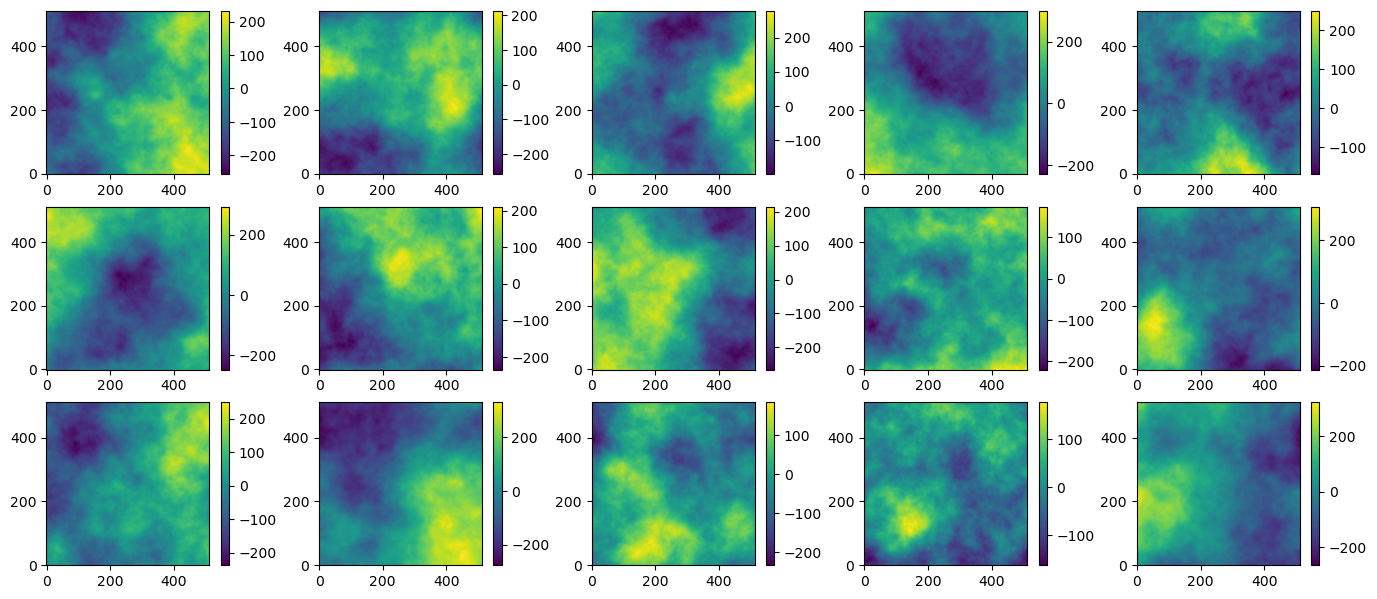

In [16]:
m2pix = 512/1.8 # pixels per meter
D = 1.8

phs = PhaseScreenGenerator(screenSizeInPixels=int(D*m2pix), screenSizeInMeters=D, outerScaleInMeters=8, seed=42)

N = 15
phs.generate_normalized_phase_screens(N)
phs.rescale_to(r0At500nm=3e-2)
phs.get_in_radians_at(wavelengthInMeters=800e-9)

# fname = 'MyPhaseScreens.fits'
# phs.save_normalized_phase_screens(fname)
# phs.load_normalized_phase_screens(fname)

screens = phs._phaseScreens

n_rows = int(xp.ceil(N/5))
plt.figure(figsize=(17,n_rows*2.4))
for i in range(N):
    plt.subplot(n_rows,5,1+i)
    plt.imshow(screens[i,:,:],origin='lower')
    plt.colorbar()

In [17]:
phs = PhaseScreenGenerator(screenSizeInPixels=512, screenSizeInMeters=1.8, outerScaleInMeters=8, seed=42)
phs.generate_normalized_phase_screens(1)

phase = phs._phaseScreens[0]*pix2rad*700
input_wavefront = mask.asTransmissionValue()*xp.exp(1j*phase)

wavefront = input_wavefront.copy()

N = 8
meas_zern_amps = xp.zeros([Nmodes,N])

for i in range(N):

    intensity = wfs.modulate(wavefront, alpha/pix2rad, N_steps=16)
    slopes = ccd.compute_slopes(intensity)
    meas_zern_amps[:,i] = Rec @ slopes
    meas_zern_ids = xp.arange(Nmodes)+2

    cmd_wavefront = create_field_from_zernike_coefficients(mask, meas_zern_ids, meas_zern_amps[:,i])

    wavefront *= xp.exp(-1j*xp.angle(cmd_wavefront))

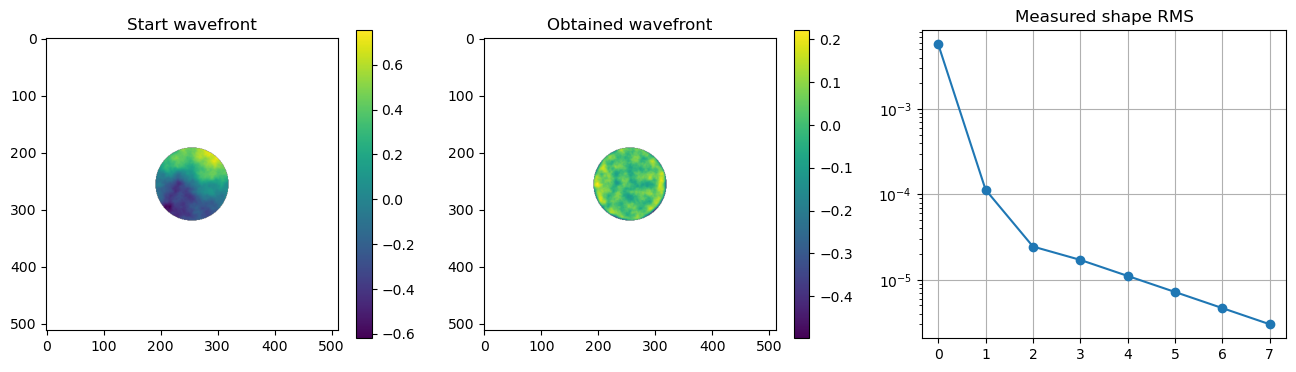

In [18]:
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.imshow(xp.ma.masked_array(xp.angle(input_wavefront),mask=mask.mask()))
plt.colorbar()
plt.title('Start wavefront')

plt.subplot(1,3,2)
plt.imshow(xp.ma.masked_array(xp.angle(wavefront),mask=mask.mask()))
plt.colorbar()
plt.title('Obtained wavefront')

plt.subplot(1,3,3)
plt.plot(xp.arange(N),xp.sqrt(xp.sum(meas_zern_amps**2,axis=0))/Nmodes,'-o')
plt.grid()
plt.title('Measured shape RMS')
plt.yscale('log')

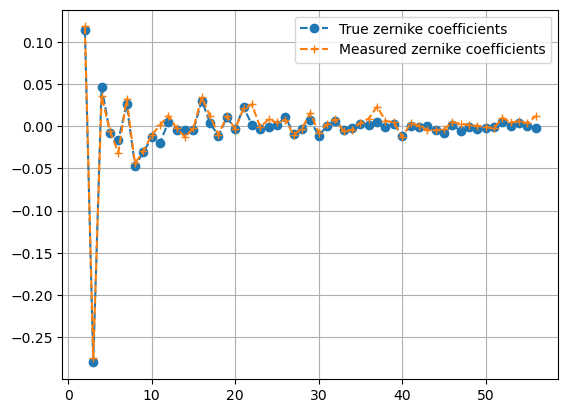

In [19]:
true_zern_amps = xp.linalg.pinv(ZM) @ xp.angle(input_wavefront)[~mask.mask()]
plt.figure()
plt.plot(meas_zern_ids,true_zern_amps,'--o',label='True zernike coefficients')
plt.plot(meas_zern_ids,xp.sum(meas_zern_amps,axis=1),'--+',label='Measured zernike coefficients')
plt.legend()
plt.grid()

In [20]:
# Deformable mirror
from ekarus.e2e.alpao_deformable_mirror import ALPAODM
tn = '20250217_160029' 
dm = ALPAODM(tn)

In [21]:
# # Get the ALPAO 'stiffness' matrix
# CMat = dm.CMat
# IFF = dm.IFF

# IM = IFF @ xp.linalg.pinv(CMat)

# U,D,V = xp.linalg.svd(IM,full_matrices=False)

# plt.figure()
# plt.plot(D,'o')

In [22]:
# plt.figure(figsize=(12,6))
# plt.subplot(2,4,1)
# dm.plot_surface(U[:,0])
# plt.colorbar()
# plt.subplot(2,4,2)
# dm.plot_surface(U[:,1])
# plt.colorbar()
# plt.subplot(2,4,3)
# dm.plot_surface(U[:,2])
# plt.colorbar()
# plt.subplot(2,4,4)
# dm.plot_surface(U[:,3])
# plt.colorbar()
# plt.subplot(2,4,5)
# dm.plot_surface(U[:,-4])
# plt.colorbar()
# plt.subplot(2,4,6)
# dm.plot_surface(U[:,-3])
# plt.colorbar()
# plt.subplot(2,4,7)
# dm.plot_surface(U[:,-2])
# plt.colorbar()
# plt.subplot(2,4,8)
# dm.plot_surface(U[:,-1])
# plt.colorbar()

In [23]:
from arte.math.factors import lcm
from arte.utils.rebin import rebin

def rebin_dm_image_to_mask(surf, dm, nx:int = 128, oversampling: int = 4):

    newshape = (nx,nx)

    val_ids = xp.arange(xp.size(dm.mask))
    pix_ids = val_ids[~dm.mask.flatten()]
    img = xp.zeros(xp.size(dm.mask))
    img[pix_ids] = surf
    img = xp.reshape(img, xp.shape(dm.mask))

    mcmx = lcm(img.shape[0], newshape[0])
    mcmy = lcm(img.shape[1], newshape[1])

    temp = rebin(img, (mcmx, img.shape[1]), sample=True)
    temp = rebin(temp, (newshape[0], img.shape[1]))
    temp = rebin(temp, (newshape[0], mcmy), sample=True)
    rebinned = rebin(temp, newshape)

    resampled = xp.pad(rebinned, (oversampling-1)*nx//2)

    return resampled

def rebin_mask_image_to_dm(image, mask, dm, oversampling: int = 4):

    (nx,ny) = mask.mask().shape
    trueshape = (nx//oversampling, ny//oversampling)

    temp = xp.angle(image)
    img = temp[(nx-trueshape[0])//2:(nx+trueshape[0])//2, (ny-trueshape[1])//2:(ny+trueshape[1])//2]

    newshape = dm.mask.shape

    mcmx = lcm(img.shape[0], newshape[0])
    mcmy = lcm(img.shape[1], newshape[1])

    temp = rebin(img, (mcmx, img.shape[1]), sample=True)
    temp = rebin(temp, (newshape[0], img.shape[1]))
    temp = rebin(temp, (newshape[0], mcmy), sample=True)
    rebinned = rebin(temp, newshape)

    surf = rebinned[~dm.mask]

    return surf



In [24]:
# cmd = xp.zeros(dm.Nacts)
# cmd[1::2] = 1
# cmd[::2] = -1
# shape = dm.IFF @ cmd

# dm.plot_surface(shape)

# resampled = rebin_dm_image_to_mask(shape, dm)

# plt.figure()
# plt.imshow(xp.ma.masked_array(resampled,mask=mask.mask()))

In [25]:
# dm_wavefront = create_field_from_zernike_coefficients(mask, meas_zern_ids, meas_zern_amps[:,0])

# plt.figure()
# plt.imshow(xp.ma.masked_array(xp.angle(dm_wavefront),mask=mask.mask()))

# dm_surf = rebin_mask_image_to_dm(dm_wavefront, mask, dm)

# plt.figure()
# dm.plot_surface(dm_surf)

In [26]:
zern_ids = xp.arange(Nmodes)+2
zern_amps = xp.random.randn(Nmodes)*0.2

input_wavefront = create_field_from_zernike_coefficients(mask, zern_ids, zern_amps)
wavefront = input_wavefront.copy()

N = 8
meas_zern_amps = xp.zeros([Nmodes,N])

for i in range(N):

    intensity = wfs.modulate(wavefront, alpha/pix2rad, N_steps=16)
    slopes = ccd.compute_slopes(intensity)
    meas_zern_amps[:,i] = Rec @ slopes
    meas_zern_ids = xp.arange(Nmodes)+2

    meas_wavefront = create_field_from_zernike_coefficients(mask, meas_zern_ids, meas_zern_amps[:,i])

    dm_surf = rebin_mask_image_to_dm(meas_wavefront, mask, dm)
    dm_cmd = dm.R @ dm_surf
    rec_surf = dm.IFF @ dm_cmd
    cmd_wavefront = rebin_dm_image_to_mask(rec_surf, dm)

    wavefront *= xp.exp(-1j*xp.angle(cmd_wavefront))